In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.applications as keras_apps
import cryptovision.tools as tools
import cryptovision.dataset as dataset
from tensorflow.keras import layers

2025-02-14 19:15:15.609 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [2]:
SEED = 42
image_size = (299, 299)
level = 'species'
epochs = 10

df = dataset.main(min_samples=90)

train_df, val_df, test_df = tools.split_dataframe(
    df,
    test_size=0.15,
    val_size=0.15,
    stratify_by='folder_label',
    random_state=SEED,
)

train_ds = tools.tensorflow_dataset(
    train_df,
    batch_size=128,
    image_size=image_size,
)

val_ds = tools.tensorflow_dataset(
    val_df,
    batch_size=128,
    image_size=image_size,
)

test_ds = tools.tensorflow_dataset(
    test_df,
    batch_size=128,
    image_size=image_size,
)

train_datasets = {
    'all': train_ds,
    'family': train_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': train_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': train_ds.map(lambda image, labels: (image, labels['species'])),
}

val_datasets = {
    'all': val_ds,
    'family': val_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': val_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': val_ds.map(lambda image, labels: (image, labels['species'])),
}

test_datasets = {
    'all': test_ds,
    'family': test_ds.map(lambda image, labels: (image, labels['family'])),
    'genus': test_ds.map(lambda image, labels: (image, labels['genus'])),
    'species': test_ds.map(lambda image, labels: (image, labels['species'])),
}

2025-02-14 19:15:20.762 | INFO     | cryptovision.dataset:main:46 - DataSet sjb loaded -> Size: (7493, 20)
2025-02-14 19:15:20.779 | INFO     | cryptovision.dataset:main:46 - DataSet scls loaded -> Size: (358, 20)
2025-02-14 19:15:20.785 | INFO     | cryptovision.dataset:main:46 - DataSet lirs loaded -> Size: (877, 20)
2025-02-14 19:15:20.788 | INFO     | cryptovision.dataset:main:46 - DataSet cbc loaded -> Size: (362, 20)
2025-02-14 19:15:20.836 | INFO     | cryptovision.dataset:main:46 - DataSet web loaded -> Size: (6421, 20)
2025-02-14 19:15:20.879 | INFO     | cryptovision.dataset:main:46 - DataSet inat loaded -> Size: (14405, 20)
2025-02-14 19:15:20.881 | INFO     | cryptovision.dataset:main:52 - Initial DataSet Size: 29,916
2025-02-14 19:15:20.883 | INFO     | cryptovision.dataset:main:53 - Fam 28 | Gen 81 | Spec 190
2025-02-14 19:15:20.892 | INFO     | cryptovision.dataset:main:57 - Number of duplicates: 0
2025-02-14 19:15:20.896 | INFO     | cryptovision.dataset:main:62 - Filtr

2025-02-14 19:15:20.935122: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-14 19:15:20.935154: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-02-14 19:15:20.935157: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-02-14 19:15:20.935171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-14 19:15:20.935179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
# Build Model

# Augmentation
augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal", seed=SEED),
        layers.RandomRotation(0.1, seed=SEED),
        layers.RandomZoom(height_factor=(0.05, 0.1), width_factor=(0.05, 0.1), seed=SEED),  # Wider zoom range
        layers.RandomContrast(0.2, seed=SEED),
        layers.RandomBrightness(0.2, seed=SEED),
        layers.RandomTranslation(0.1, 0.1, seed=SEED),
        layers.RandomCrop(image_size[0], image_size[1], seed=SEED),
        layers.GaussianNoise(0.1, seed=SEED),
    ],
    name='augmentation'
)

# Pre-trained Model
pretrain = keras_apps.ResNet50V2(include_top=False, weights='imagenet', input_shape=(image_size[0], image_size[1], 3))
pretrain.trainable = False

def pretrain_model(backbone, preprocess, input_shape=(224, 224, 3), name=None, augmentation=None):
    
    inputs = layers.Input(shape=input_shape, name='input_layer')
    x = augmentation(inputs) if augmentation else inputs
    x = preprocess(x)
    x = backbone(x, training=False)
    
    return tf.keras.Model(inputs, x, name=name)

def dense_block(input_layer, name:str, units:int, dropout:float, activation:str='relu', norm:bool=True):
    
    x = layers.Dense(units, name=name)(input_layer)
    if norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout)(x)
    return x

feature_extractor = pretrain_model(
    pretrain, 
    keras_apps.resnet_v2.preprocess_input, 
    input_shape=(image_size[0], image_size[1], 3), 
    name='feature_extractor',
    augmentation=augmentation
)

# Eviota Model
features = layers.GlobalAveragePooling2D(name='GlobAvgPool2D')(feature_extractor.output)
hidden_layer = dense_block(features, 'hidden_layer', 512, 0.2)

# Species Output
species_output = layers.Dense(df[level].nunique(), activation='softmax', name='species')(hidden_layer)

model = tf.keras.Model(
    feature_extractor.input,
    species_output,
    name='LevelModel_' + level
)

#model.summary(show_trainable=True)

In [11]:
pretrain = model.layers[2]
pretrain.trainable = True
for layer in pretrain.layers[:-50]:
    layer.trainable = False
    
model.summary(show_trainable=True)

Model: "LevelModel_species"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ cast_5 (Cast)               │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ augmentation (Sequential)   │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ true_divide_2 (TrueDivide)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ subtract_2 (Subtract)       │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ resnet50v2 (Functional)     │ (None, 4, 4, 2048)    │ 23,564,800 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ GlobAvgPool2D               │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ hidden_layer (Dense)        │ (None, 512)           │  1,049,088 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_2       │ (None, 512)           │      2,048 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_2 (Activation)   │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ species (Dense)             │ (None, 114)           │     58,482 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 24,674,418 (94.13 MB)

 Trainable params: 17,460,850 (66.61 MB)

 Non-trainable params: 7,213,568 (27.52 MB)

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

In [13]:
history = model.fit(
    train_datasets[level],
    epochs=epochs,
    validation_data=val_datasets[level],
    verbose=1
)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 76s 426ms/step - accuracy: 0.1157 - loss: 4.3877 - val_accuracy: 0.4013 - val_loss: 2.5874
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.4800 - loss: 2.2695

KeyboardInterrupt: 

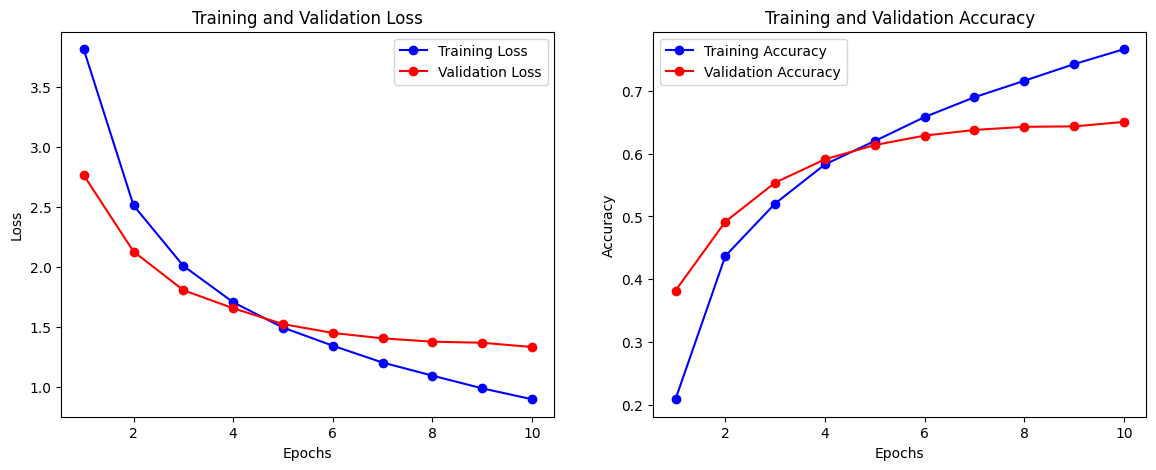

In [8]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss from a Keras History object.
    
    Parameters:
    -----------
    history : keras.callbacks.History
        The History object returned by model.fit().
    """
    # Retrieve metrics from the history object
    acc      = history.history.get('accuracy', [])
    val_acc  = history.history.get('val_accuracy', [])
    loss     = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])
    
    epochs = range(1, len(loss) + 1)
    
    # Create subplots for loss and accuracy
    plt.figure(figsize=(14, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Example usage:
plot_training_history(history)
